# Advanced methods for training ANNs

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)


2. [Backpropagation (Bprop) family of methods](#bprop) 

  2.1. [Regular backprop](#bprop-1)
  
  2.2. [Backprop with momentum](#bprop-1-mom)

  2.3. [Backprop with momentum and $L_2$ regularization](#bprop-11)
  
  2.4. [Backprop with momentum and decoupled decay](#bprop-12)


3. [Resilient propagation (Rprop) family of methods](#rprop) 

  3.1. [The most basic Rprop - without error backtracking](#rprop-minus)


### A. Learning objectives

- to train an ANN to approximate analytical functions
- to explore several algorithms for ANN training 
- to be aware of the importance of the initial weights/biases initialization 

### B. Use cases

- ANN training with Backprop
- ANN training with Rprop
- Momentum term in ANN training
- Weight decay in ANN training


### C. Functions

None
  
  
### D. Classes and class members

- `liblibra::libann`
  - [`NeuralNetwork`](#NeuralNetwork-1)        
    - [`train`](#train-1)
    - [`propagate`](#propagate-1)
    - [`init_weights_biases_uniform`](#init_weights_biases_uniform-1)
    - [`save`](#save-1)
    
    
- `libra_py`
  - `data_conv`  
    - [`MATRIX2nparray`](#MATRIX2nparray-1)
  - `data_visualize`
    - [`plot_map`](#plot_map-1)


## 1. General setups
<a name="setups"></a> [Back to TOC](#TOC)

In [10]:
import math
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py import data_outs, data_conv, data_visualize
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

In this tutorial, we will be approximating the 2D function $z = \frac{1}{2} sin(x) cos(y)$ for $(x,y) \in [-2.0, 2.0] \times [-2.0, 2.0]$ which we also used in the previous tutorial.

However, here, we will explore other methods for ANN training and study their efficiencies.

In [11]:
nx, ny = 21, 21

x_grid = []
for i in range(nx):
    x_grid.append(  -2 + 4.0*i/float(nx-1) )
    
y_grid = []
for i in range(ny):
    y_grid.append(  -2 + 4.0*i/float(ny-1) )


Sample patterns

In [12]:
inputs = MATRIX(2, nx*ny)
outputs = MATRIX(1, nx*ny)

z_ref_1D = np.zeros( (nx*ny), dtype=float )

cnt = 0
for i in range(nx):
    for j in range(ny):    
                
        z = 0.5*math.sin(2.0*x_grid[i])*math.cos(3.0*y_grid[j])
        z_ref_1D[cnt] = z
        
        inputs.set(0, cnt, x_grid[i])
        inputs.set(1, cnt, y_grid[j])
        outputs.set(0, cnt, z)
        
        cnt = cnt + 1

In [13]:
rnd = Random()

## 2. Backpropagation method
<a name="bprop"></a> [Back to TOC](#TOC)

The error back-propagation ("BProp") algorithm is the most common and basic approach for training ANNs. 

However, there are several improvements that can be added within the BProp framework. In this section, we will illustrate such of these options

As a reference, here we summarize the keywords that the `train` function parameters dictionary can have:

* `learning_method` - selects the method for the ANN training, the selection goes as following

  -  1 [default] Back Propagation (BProp) and options, no momentum, Algorithm 1 of [2], neither purple nor green
  - 11 BProp with L2 regularization - Algorithm 1 of [2], purple option
  - 12 BProp with decoulpled decay  - Algorithm 1 of [2], green option
  - 13 [under development] Adam with L2 regularization - Algorithm 2 of [2], purple option
  - 14 [under development] Adam with decoupled decay - Algorithm 2 of [2], green option
  - 2  Resilient Propagation without weight-backtracking (RProp-) - Eq. 1 of [3] + section 2.2
  - 21 [under development] Resilient Propagation with weight-backtracking (RProp+) - Eq. 1 of [3] + section 2.1
  - 22 [under development] Modified RProp- (iRprop-)
  - 23 [under development] Modified RProp+ (iRprop+)

* `learning_rate` [default: 0.001] - the timestep size,  $\alpha$ in algorithm (1) of [2]
  

* `momentum_term` [default: 0.0] - the momentum term control parameter, $\beta_1$ in algorithm (1) of [2]
  
  
* `weight_decay_lambda` [default: 0.0] - the L2 regularization factor  L_new = L_old + lambda * w^T w, $\lambda$ in algorithm (1) of [2]


* `etha` [default: 1.0] - the control parameter for the decoupled weight decay, the $\eta_t$ in algorithm (1) of [2]


* `num_epochs` [default: 1] - the number of training epochs to do


* `steps_per_epoch` [default: 1] - the number of steps per epoch 


* `epoch_size` [default: 1] - how many patterns to include in each step of each epoch


* `verbosity`  [default : 0] - the level of additional printing


* `error_collect_frequency` [default: 1] - how often to collect the information on errors, 1 means every training step


* `a_plus` [default: 1.1] - the RProp step size multiplication (increase) parameter - good for up to 1.2, corresponds to $\eta^{+}$ parameter of [3]


* `a_minus` [default: 0.6] - the RProp step size multiplication (decrease) parameter - good for down to 0.5, corresponds to $\eta^{-}$ parameter of [3]


* `dB_min` [default: $0.1\times $`learning_rate` ] - the minimal acceptable timestep for B updates in the RProp family of methods


* `dB_max` [default: $1.0\times $`learning_rate` ] - the maximal acceptable timestep for B updates in the RProp family of methods


* `dW_min` [default: $0.1\times $`learning_rate` ] - the minimal acceptable timestep for W updates in the RProp family of methods


* `dW_max` [default: $1.0\times $`learning_rate` ] - the maximal acceptable timestep for W updates in the RProp family of methods



  **References for the above parameters**:
  1. [http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf](http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf)
  2. [https://arxiv.org/pdf/1711.05101.pdf](https://arxiv.org/pdf/1711.05101.pdf)
  3. [http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.17.1332](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.17.1332)



### 2.1. Regular backprop
<a name="bprop-1"></a> [Back to TOC](#TOC)

This option is selected by:

* `"learning_method":1` - the method selector

* `"momentum_term": 0.00` - althought, technically, the momentum term is still in this algorithm, setting this parameter to zero effectively removes the momentum term

Yet, the training result is pretty good. 

**IMPORTANT**: (almost) no matter what the method and parameters you choose, starting with good guess parameters is SO MUCH important for obtaining good results. While preparing this tutorial, I initially had the weights and biases initializations done as:

    ANN.init_weights_biases_uniform(rnd, -0.1, 0.1, -0.1, 0.1)
    
It produced descent results only sporadiaclly. Having somewhat larger initial weights does help here.  
<a name="NeuralNetwork-1"></a><a name="init_weights_biases_uniform-1"></a><a name="train-1"></a><a name="propagate-1"></a><a name="save-1"></a>

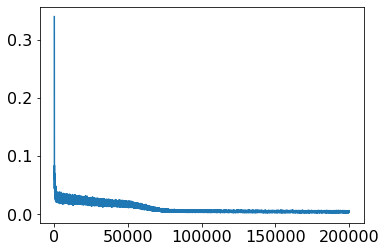

In [5]:
ANN = NeuralNetwork( Py2Cpp_int( [2, 15, 1] ) )
last_indx = 2   # index of the layer that contains the target output - the architecture-dependent parameter
ANN.init_weights_biases_uniform(rnd, -1.1, 1.1, -1.1, 1.1)


params = { "num_epochs":20, 
           "steps_per_epoch":10000,            
           "epoch_size":100, 
           "verbosity":1,
           "error_collect_frequency":1,
          
           "learning_method":1,
           "learning_rate":0.01, 
          
           "weight_decay_lambda":0.00,
           "etha":1.0,
           "momentum_term": 0.0,           
           "a_plus":1.1, "a_minus":0.60,
           "dB_min":0.000001, "dB_max":10.1,
           "dW_min":0.000001, "dW_max":10.1,          
        }


err = ANN.train(rnd, params, inputs, outputs )

ANN.save("bprop_ann.xml")

Y = ANN.propagate(inputs)

y = Cpp2Py(err)
x = list( range(len(y)))

plt.plot(x, y)

Plot results
<a name="MATRIX2nparray-1"></a><a name="plot_map-1"></a>


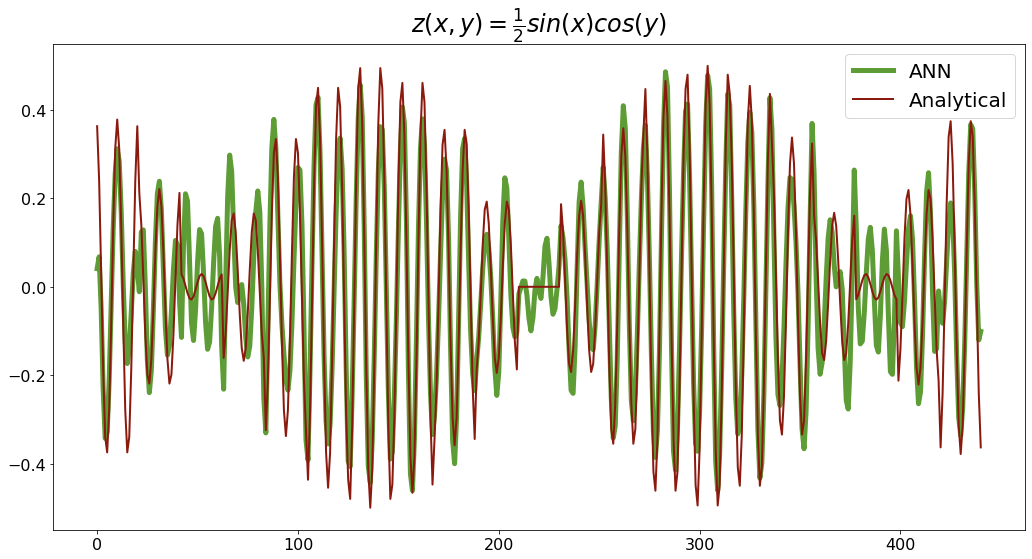

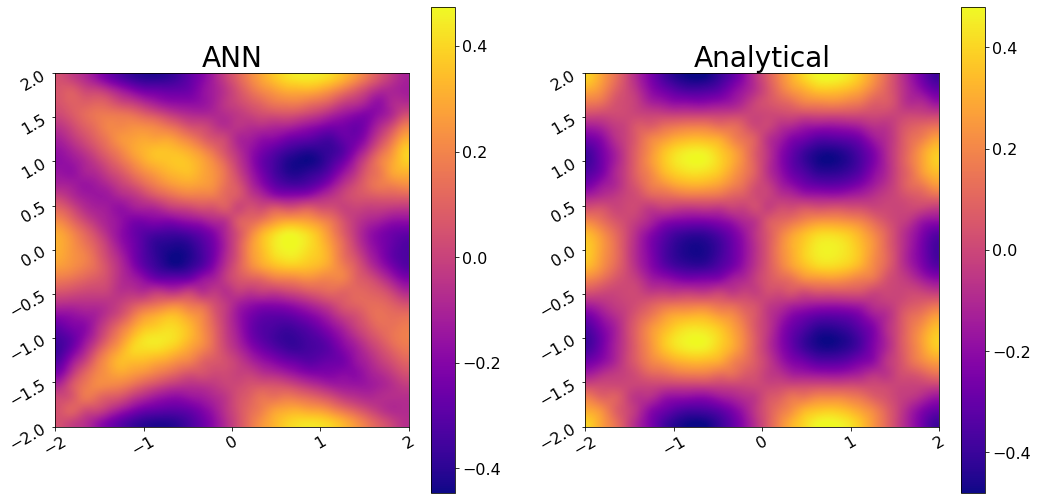

In [6]:
z = data_conv.MATRIX2nparray(Y[last_indx], float)[0, :]

indx = list( range( len(z) ))
plt.figure(1, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.plot(indx, z, label="ANN", linewidth=5, color=colors["21"])
plt.plot(indx, z_ref_1D, label="Analytical", linewidth=2, color=colors["11"])
plt.legend()

plt.rc('axes', titlesize=28)
plt.figure(2, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.subplot(1,2,1)
plt.title("ANN")
data_visualize.plot_map(plt, x_grid, y_grid, z.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="bprop.png")

plt.subplot(1,2,2)
plt.title("Analytical")
data_visualize.plot_map(plt, x_grid, y_grid, z_ref_1D.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="ref.png")

### 2.2. Backprop with momentum
<a name="bprop-1-mom"></a> [Back to TOC](#TOC)

Here, we also consider adding the momentum term. This term helps remove oscillations of the ANN parameters during its training and therefore helps with the convergence and accuracy.

This option is selected by: 

* `"learning_method":1` - the same option as the regular BProp, but the inclusion of the momentum term is controlled by the parameters below


* `"momentum_term": 0.75` - tells what weight to give to the previous dW or dB in the computing of the new ones. Setting this parameter to 0.0 is equivalent to not having the momentum terms

As we can see, this method gives quite good results and faster convergence than the regular BProp.

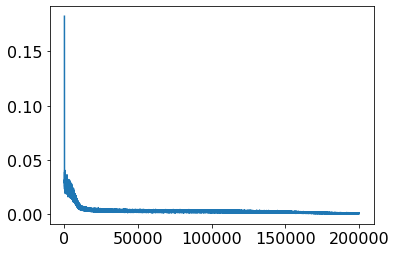

In [7]:
ANN = NeuralNetwork( Py2Cpp_int( [2, 15, 1] ) )
last_indx = 2
ANN.init_weights_biases_uniform(rnd, -1.1, 1.1, -1.1, 1.1)

params = { "num_epochs":20, 
           "steps_per_epoch":10000,            
           "epoch_size":100, 
           "verbosity":1,
           "error_collect_frequency":1,
          
           "learning_method":1,
           "learning_rate":0.01, 
          
           "weight_decay_lambda":0.0000,
           "etha":1.0,
           "momentum_term": 0.75,           
           "a_plus":1.1, "a_minus":0.60,
           "dB_min":0.000001, "dB_max":10.1,
           "dW_min":0.000001, "dW_max":10.1,          
        }


err = ANN.train(rnd, params, inputs, outputs )

Y = ANN.propagate(inputs)

y = Cpp2Py(err)
x = list( range(len(y)))

plt.plot(x, y)

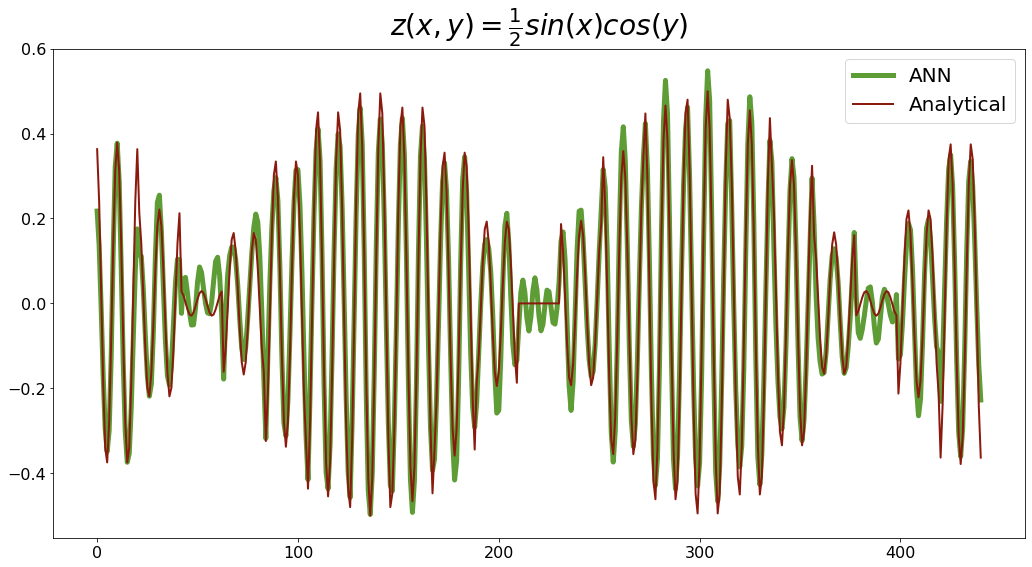

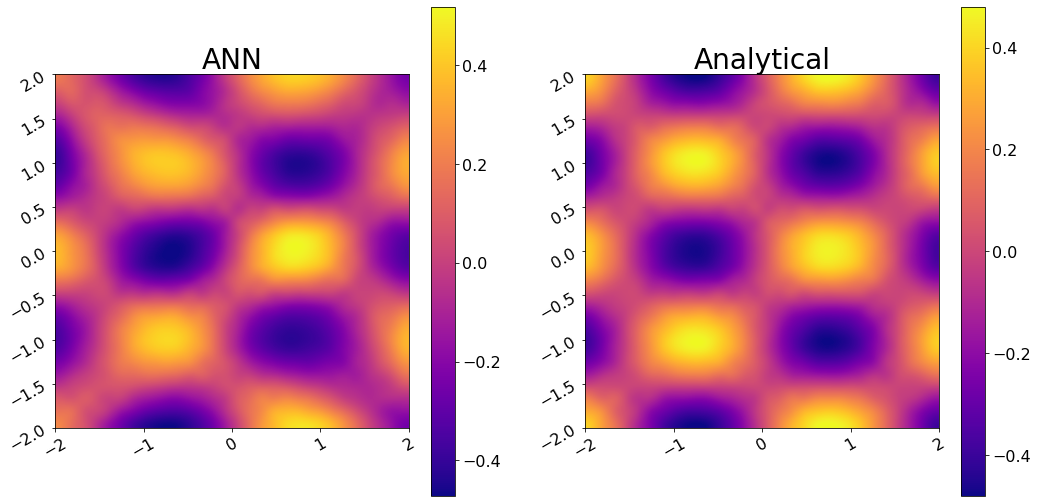

In [8]:
z = data_conv.MATRIX2nparray(Y[last_indx])[0][:]

indx = list( range( len(z) ))
plt.figure(1, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.plot(indx, z, label="ANN", linewidth=5, color=colors["21"])
plt.plot(indx, z_ref_1D, label="Analytical", linewidth=2, color=colors["11"])
plt.legend()

plt.rc('axes', titlesize=28)
plt.figure(2, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.subplot(1,2,1)
plt.title("ANN")
data_visualize.plot_map(plt, x_grid, y_grid, z.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="bprop-mom.png")

plt.subplot(1,2,2)
plt.title("Analytical")
data_visualize.plot_map(plt, x_grid, y_grid, z_ref_1D.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="ref.png")

### 2.3. Backprop with momentum and $L_2$ regularization
<a name="bprop-11"></a> [Back to TOC](#TOC)

This option is selected by 

* `"learning_method":11`


* `"weight_decay_lambda":0.001` and `"etha":1.0` - control the rate of the weight decay, and it is coupled to the momentum updates


* `"momentum_term": 0.75` - the momentum term is still used

This method gives quite good results. In contrast to the method without the regularization, it produces somewhat more symmetric results.

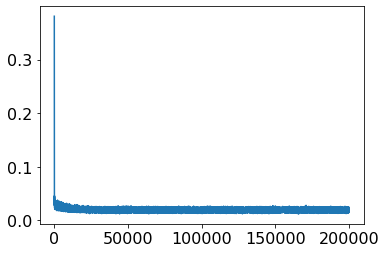

In [9]:
ANN = NeuralNetwork( Py2Cpp_int( [2, 15, 1] ) )
last_indx = 2
ANN.init_weights_biases_uniform(rnd, -1.1, 1.1, -1.1, 1.1)

params = { "num_epochs":20, 
           "steps_per_epoch":10000,            
           "epoch_size":100, 
           "verbosity":1,
           "error_collect_frequency":1,
          
           "learning_method":11,
           "learning_rate":0.01, 
          
           "weight_decay_lambda":0.001,
           "etha":1.0,
           "momentum_term": 0.75,           
           "a_plus":1.1, "a_minus":0.60,
           "dB_min":0.000001, "dB_max":10.1,
           "dW_min":0.000001, "dW_max":10.1,          
        }


err = ANN.train(rnd, params, inputs, outputs )

Y = ANN.propagate(inputs)

y = Cpp2Py(err)
x = list( range(len(y)))

plt.plot(x, y)

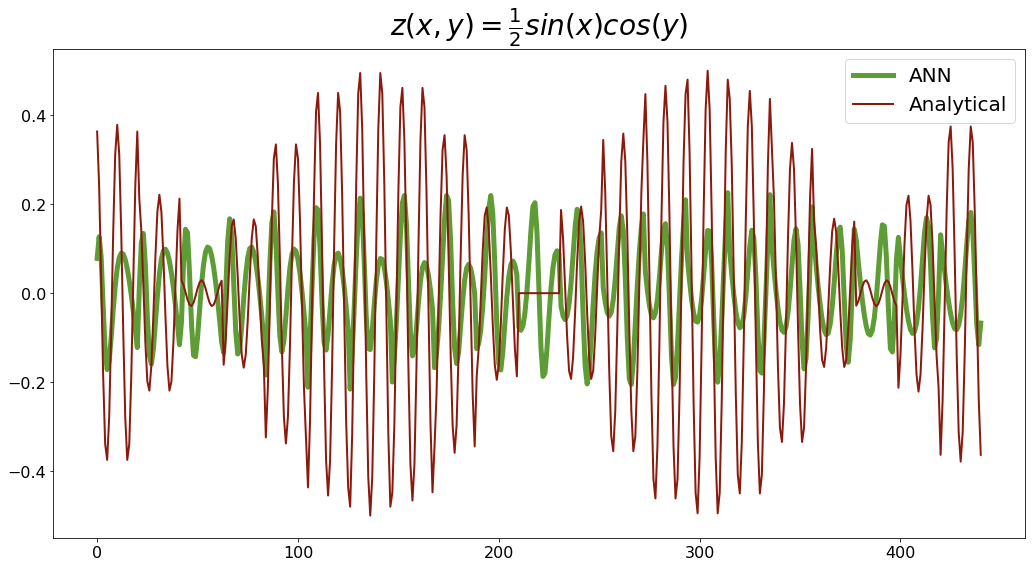

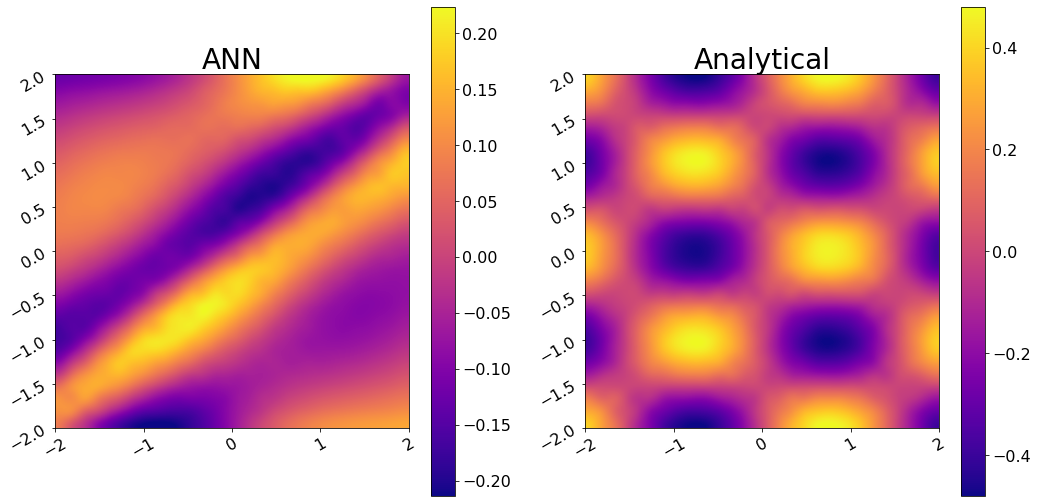

In [10]:
z = data_conv.MATRIX2nparray(Y[last_indx])[0][:]

indx = list( range( len(z) ))
plt.figure(1, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.plot(indx, z, label="ANN", linewidth=5, color=colors["21"])
plt.plot(indx, z_ref_1D, label="Analytical", linewidth=2, color=colors["11"])
plt.legend()

plt.rc('axes', titlesize=28)
plt.figure(2, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.subplot(1,2,1)
plt.title("ANN")
data_visualize.plot_map(plt, x_grid, y_grid, z.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="bprop-mom-l2.png")

plt.subplot(1,2,2)
plt.title("Analytical")
data_visualize.plot_map(plt, x_grid, y_grid, z_ref_1D.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="ref.png")

### 2.4. Backprop with momentum and decoupled decay
<a name="bprop-12"></a> [Back to TOC](#TOC)

This option is selected by 

* `"learning_method":12`


* `"weight_decay_lambda":0.00001` and `"etha":1.0` - control the rate of the weight decay, but it is decoupled from the momentum


* `"momentum_term": 0.75` - the momentum term is still used

Somehow, this is not the best option

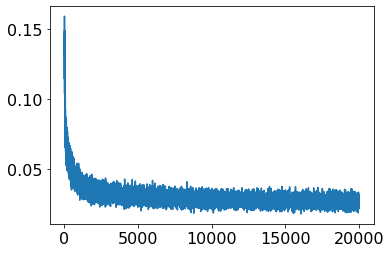

In [11]:
ANN = NeuralNetwork( Py2Cpp_int( [2, 15, 1] ) )
last_indx = 2
ANN.init_weights_biases_uniform(rnd, -1.1, 1.1, -1.1, 1.1)

params = { "num_epochs":20, 
           "steps_per_epoch":1000,            
           "epoch_size":100, 
           "verbosity":1,
           "error_collect_frequency":1,
          
           "learning_method":12,
           "learning_rate":0.001, 
          
           "weight_decay_lambda":0.00001,
           "etha":1.0,
           "momentum_term": 0.75,           
           "a_plus":1.1, "a_minus":0.60,
           "dB_min":0.000001, "dB_max":10.1,
           "dW_min":0.000001, "dW_max":10.1,          
        }


err = ANN.train(rnd, params, inputs, outputs )

Y = ANN.propagate(inputs)

y = Cpp2Py(err)
x = list( range(len(y)))

plt.plot(x, y)

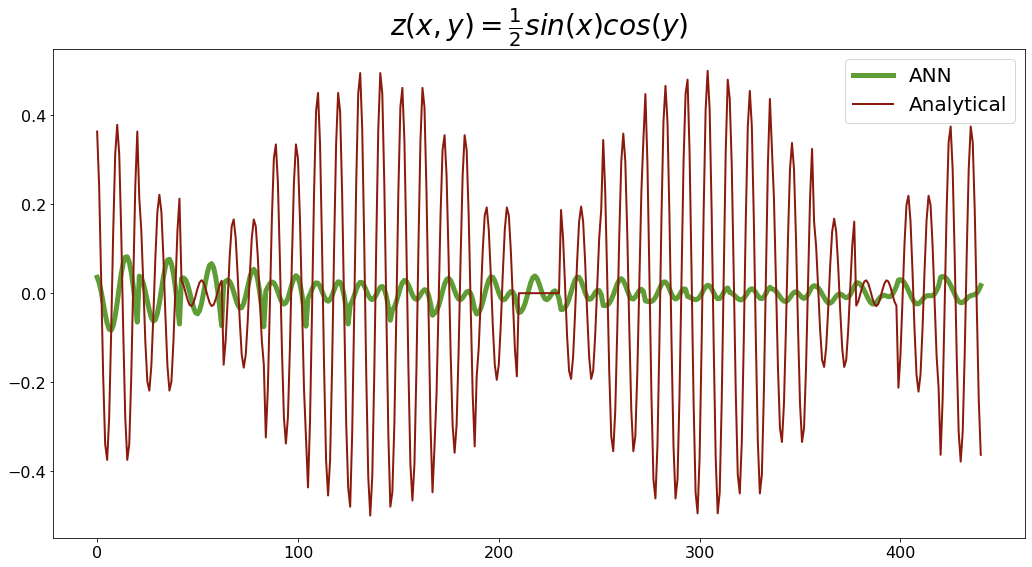

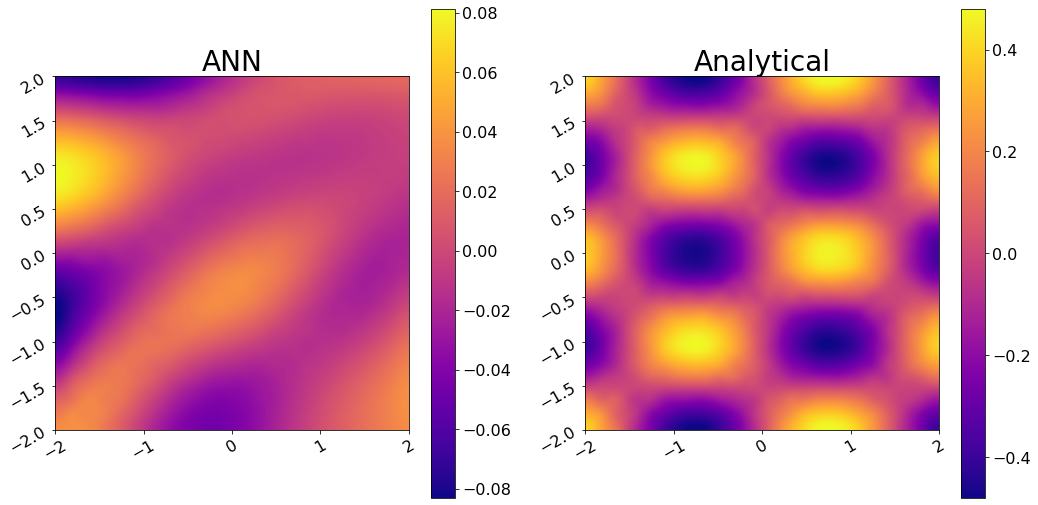

In [12]:
z = data_conv.MATRIX2nparray(Y[last_indx])[0][:]

indx = list( range( len(z) ))
plt.figure(1, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.plot(indx, z, label="ANN", linewidth=5, color=colors["21"])
plt.plot(indx, z_ref_1D, label="Analytical", linewidth=2, color=colors["11"])
plt.legend()

plt.rc('axes', titlesize=28)
plt.figure(2, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.subplot(1,2,1)
plt.title("ANN")
data_visualize.plot_map(plt, x_grid, y_grid, z.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="bprop-decoupled-decay.png")

plt.subplot(1,2,2)
plt.title("Analytical")
data_visualize.plot_map(plt, x_grid, y_grid, z_ref_1D.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="ref.png")

## 3. Resilient propagation (Rprop) family of methods
<a name="rprop"></a> [Back to TOC](#TOC)

More theory can be found in:

* [http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf](http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf)

* [http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.17.1332](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.17.1332)


### 3.1. The most basic Rprop - without error backtracking
<a name="rprop-minus"></a> [Back to TOC](#TOC)

Pay attention to:

* `"learning_method":2` - selects the basic Rprop (Rprop-)


* `"epoch_size":400` - the epoch size can be set to anything here, but it will be reset to the size of the entire sample (the total number of samples)


* `learning_rate` - defines the initial size of the dW and dB


* `"a_plus":1.1` and `"a_minus":0.60` - define the speed of increasing/decreasing the step size. Remember - the step size is defined only by the signs of the gradients at consecutive steps, but not by the gradient magnitudes.


* `"dB_min":0.0001`, `"dB_max":10.1`, `"dW_min":0.0001`, `"dW_max":10.1` - these are the parameters that define the bounds of the dB and dW parameters, so that we don't run into troubles



As we can see, the convergence is pretty good and the resulting trained ANN yields pretty descent results.

What's more important is that this algorithm is in general more robust and faster-converging than the Bprop versions.

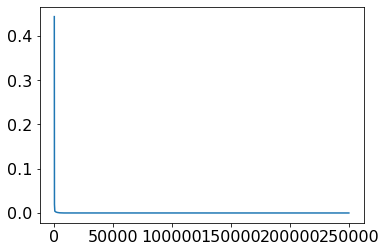

In [18]:
ANN = NeuralNetwork( Py2Cpp_int( [2, 25, 1] ) )
last_indx = 2
ANN.init_weights_biases_uniform(rnd, -1.1, 1.1, -1.1, 1.1)

params = { "num_epochs":25, 
           "steps_per_epoch":10000,            
           "epoch_size":400, 
           "verbosity":1,
           "error_collect_frequency":1,
          
           "learning_method":2,
           "learning_rate":0.01, 
          
           "weight_decay_lambda":0.00,
           "etha":1.0,
           "momentum_term": 0.75,           
           "a_plus":1.1, "a_minus":0.60,
           "dB_min":0.00001, "dB_max":100.1,
           "dW_min":0.00001, "dW_max":100.1,          
        }


err = ANN.train(rnd, params, inputs, outputs )

Y = ANN.propagate(inputs)

y = Cpp2Py(err)
x = list( range(len(y)))

plt.plot(x, y)

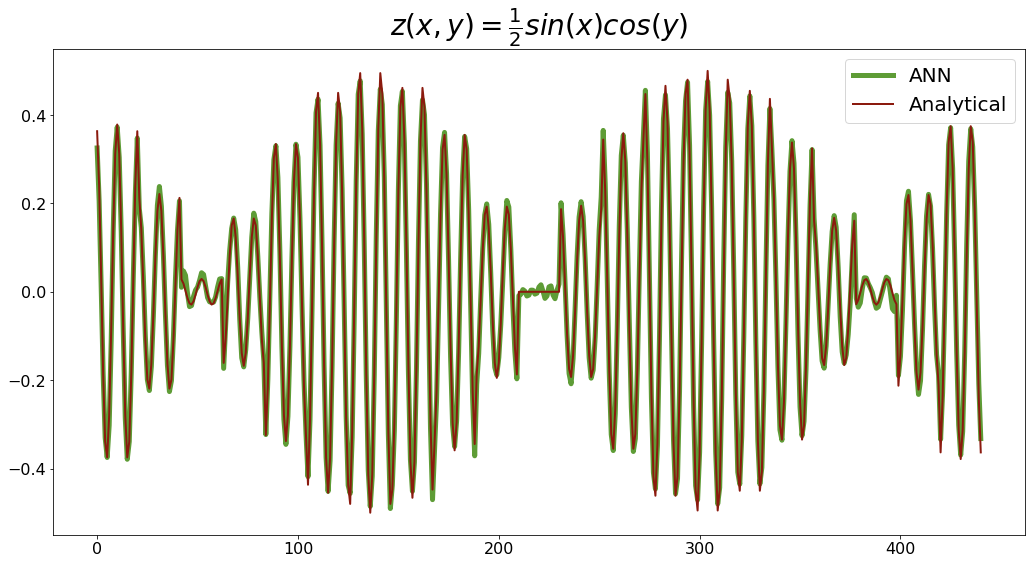

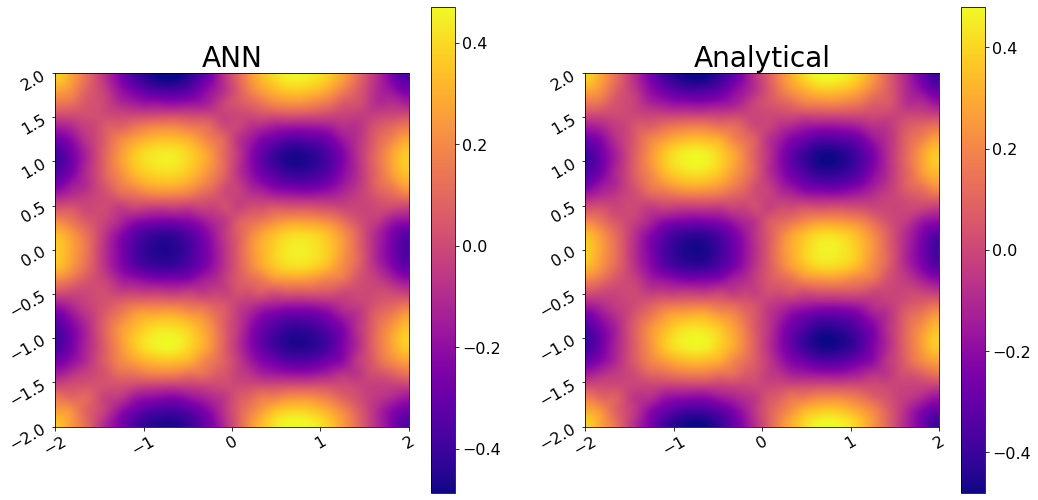

In [19]:
z = data_conv.MATRIX2nparray(Y[last_indx], float)[0][:]

indx = list( range( len(z) ))
plt.figure(1, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.plot(indx, z, label="ANN", linewidth=5, color=colors["21"])
plt.plot(indx, z_ref_1D, label="Analytical", linewidth=2, color=colors["11"])
plt.legend()

plt.rc('axes', titlesize=28)
plt.figure(2, figsize=(18, 9))
plt.title("$ z(x,y) = \\frac{1}{2} sin(x) cos(y)$")
plt.subplot(1,2,1)
plt.title("ANN")
data_visualize.plot_map(plt, x_grid, y_grid, z.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="rprop.png")

plt.subplot(1,2,2)
plt.title("Analytical")
data_visualize.plot_map(plt, x_grid, y_grid, z_ref_1D.reshape(nx, ny), colormap="plasma", resolution=30j, savefig=1, figure_name="ref.png")